<a href="https://colab.research.google.com/github/jadercaro/Prediccion-de-desercion-universitaria/blob/main/G_DB_6_JaderCaro_JaglerVelasquez_AlejandroArias_desercion_KNN_Parzen_clasificacion_sem_2024_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Recuerda que una vez abierto, Da clic en "Copiar en Drive", de lo contrario no podras alamancenar tu progreso**

Nota: no olvide ir ejecutando las celdas de código de arriba hacia abajo para que no tenga errores de importación de librerías o por falta de definición de variables.

In [ ]:
#@title **Integrantes**
nombres_apellidos_integrante_1 ='Jagler Velasquez Velasquez' #@param {type:"string"}
nombres_apellidos_integrante_2 = 'Alejandro Arias Ortiz'  #@param {type:"string"}
nombres_apellidos_integrante_3 = 'Jhon Jader Caro Sanchez'  #@param {type:"string"}

In [ ]:
#@title **Base de datos**
G_DB_='6' #@param {type:"string"}

In [ ]:
#Importing all the dependencies
%load_ext autoreload
%autoreload 2
in_colab = True
import os
import sys ; sys.path.append('../drive/MyDrive/Colab Notebooks/local/data');
import pandas as pd
import numpy as np
from numpy import random
from matplotlib import pyplot as plt

from scipy.stats import mode
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from numpy import random
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# **Parte 1. Problema de clasificación**

**Contextualización del problema**
En este ejercicio de clasificación o regresión logística, nuestro objetivo es predecir el estado futuro de los estudiantes: desertar, graduarse o continuar matriculado. Para lograrlo, utilizaremos diversas variables predictoras, entre las que se incluyen:

1. **Nota del segundo semestre**
2. **Edad**
3. **Deudor**
4. **Horario de asistencia**
5. **Matricula al días**
3. **Target** (0 para Deserción, 1 Matriculado, 2 para Graduado)

 Estas variables fueron seleccionadas debido a su fuerte relación con la variable objetivo, basándonos en criterios como la **correlación** para relaciones entre variables categóricas y numéricas.


In [ ]:
#cargamos la bd iris desde el dataset de sklearn
from sklearn import datasets
df = pd.read_csv('clasificacion_preprocesado.csv')
df['Target'] = df['Target'].apply(lambda x: 0 if x=='Dropout' else (1 if x=='Enrolled' else 2))
x = df[['Daytime/evening attendance\t','Debtor','Age at enrollment','Tuition fees up to date','Curricular units 2nd sem (grade)']]
y= df['Target']

In [ ]:
print ("Dimensión de los datos de entrada: ", x.shape[0], 'muestras y', x.shape[1], 'características.')
print ("Clases en el problema: ", np.unique(y))

Dimensión de los datos de entrada:  4424 muestras y 5 características.
Clases en el problema:  [0 1 2]


**La base de datos IRIS es un problema de clasificación de más de una clase, y tener un desbalance de muestras puede ser perjudicial para el proceso de entrenamiento. Vamos a crear una función para verificar el número de muestras por clases, lo cual seguro será últil en tu problema de clasificación.**

In [ ]:
#Ejercicio de código
def muestras_por_clases (Y):
    """Función que calcula el número de muestras por cada clase
    Y: vector de numpy con las etiquetas de las muestras del conjunto X
    retorna: diccionario [int/float:int/float]
        con la estructura:{etiquetaclase1: número de muestras clase1, etiquetaclase2: número de muestras clase2}
    """
    dicto = dict(zip(np.unique(Y,return_counts=True)[0], np.unique(Y,return_counts=True)[1]))
    return (dicto)

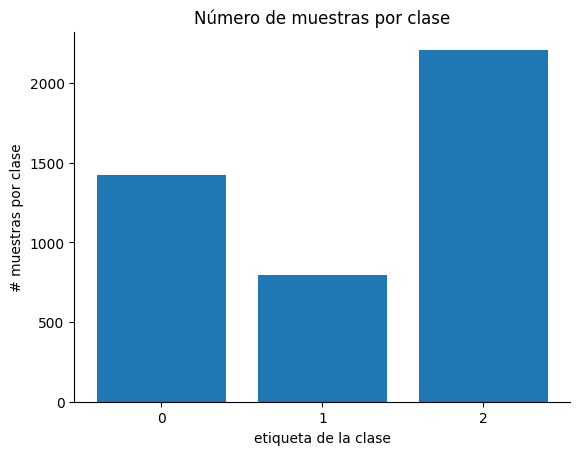

In [ ]:
# con estas línea de código puedes ver la dsitribución de forma gráfica
fig, ax = plt.subplots()
ax.bar(muestras_por_clases(y).keys(), muestras_por_clases(y).values())
ax.set_title("Número de muestras por clase")
ax.set_xlabel("etiqueta de la clase")
ax.set_ylabel("# muestras por clase")
ax.set_xticks(list(muestras_por_clases(y).keys()))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

#Balanceo de muestras
En este caso lo que se hizo fue balancear las muestras usando un UnderSampler, tomando como referencia la clase minoritaria, a pesar de que cada clase tendria aproximadamente 800 observaciones, aún sigue siendo considerable para este caso

In [ ]:
print("Antes del balanceo:", Counter(y))

#Cantidad dela muestra minoritaria
minimo = min(Counter(y).values())

# Crea un objeto RandomUnderSampler para balancear las clases
rus = RandomUnderSampler(sampling_strategy={clase: minimo for clase in Counter(y)})

# Aplica el balanceo a tus datos
X_balanceado, y_balanceado = rus.fit_resample(x, y)

# Imprime la distribución de clases después del balanceo
print("Después del balanceo:", Counter(y_balanceado))

Antes del balanceo: Counter({2: 2209, 0: 1421, 1: 794})
Después del balanceo: Counter({0: 794, 1: 794, 2: 794})


## **KNN**

In [ ]:
#@title **1. Pregunta Abierta**
#@markdown Dependiendo de los resultados de la información anterior,
#@markdown ¿cuál es la factibilidad de usar este dataset para el problema planteado?
#@markdown ¿cuál de la opciones es mejor justificada?

#@markdown A) Es factible. El gráfico de barras muestra clases desbalanceadas. El algoritmo KNN no es sensible ya que solo analiza los K-vecinos

#@markdown B) Es factible. El algoritmo KNN solo tiene en cuenta los K-vecinos más cercanos, el balance de clases es indiferente

#@markdown C) Es factible. Las clases se encuentran balanceadas, para un problema de clasificación siempre es deseable tener un buen balance entre clases

#@markdown D) No es Factible. Debemos tener mas muestras para la clase más importante

#@markdown Selecciona dentro las lista desplegable
respuesta_1 = 'C' #@param ["", "A", "B", "C", "D"]

Recordemos los conceptos vistos en teoría para los modelos basados en los K-vecimos más cercanos. En este ejercicio está definida la función que implementa este modelo. Primero se define la función que calculará el error de clasificación.

In [ ]:
def ErrorClas(Y_lest, Y):
    """funcion que calcula el error de clasificación
    Y_lest: numpy array con la estimaciones de etiqueta
    Y: etiquetas reales
    retorna: error de clasificación (int)
    """
    error = 1 - np.sum(Y_lest == Y)/len(Y)

    return error


**Ten en cuenta lo siguiente:**
1. Para el cáculo de la distancia entre vectores existen varias opciones:
    1. Usar la función la distancia entre matrices `scipy.spatial.distance.cdist`([Ejemplo](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist))--esta puede ser usada directamente como `cdist(...)`. Entiende la salida de esta función. Al usarla, se logra un rendimiento superior.
    2. Usar la función la distancia euclidiana `scipy.spatial.distance.euclidean`([Ejemplo](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html))--pueder acceder a ella directamente como `euclidean`. Aca debe pensar en un algoritmo elemento a elemento, por lo tanto menos eficiente.
2. También serán de utilidad las funciones `np.sort` y `np.argsort`.
3. Ten presente que la moda es una operación que calcula el valor más común. En el [notebook ya se encuentra cargada esta operación](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html), es posible usarla de esta manera : `mode(y)`

In [ ]:
def KNN_Clasificacion (Xtrain,Xtest, Ytrain, k):
    """ Función que implementa el modelo de K-Vecino mas cercanos
        para clasificación

    Xtrain: es la matriz con las muestras de entrenamiento
    Xtest: es la matriz con las muestras de validación
    Ytrain: es un vector con los valores de salida pra cada una de las muestras de entrenamiento
    k (int): valor de vecinos a usar

    retorna: 2 valores:
        - las estimaciones del modelo KNN para el conjunto Xtest
             esta matriz debe tener un shape de [row/muestras de Xtest]
        - las distancias de Xtest respecto a Xtrain, esta matrix
             debe tener un shape de [rows de Xtest, rows Xtrain]
             lo que es lo mismo [muestras de Xtest, muestras de Xtrain]
    """
    from scipy.spatial import distance
    from scipy.stats import mode
    if k > Xtrain.shape[0]:
        print("k no puede ser menor que las muestras de entrenamiento")
        return(None)
    N=Xtest.shape[0]
    distancias =np.zeros((N,Xtrain.shape[0]))
    Yest = np.zeros(Xtest.shape[0])
    for i in range(N):
        distancia = distance.cdist(Xtest[i].reshape(1,np.size(Xtest[i],0)),Xtrain)[0]
        index = np.argsort(distancia)
        j = index[0:k]
        Yest[i] = mode(Ytrain[j])[0]
        distancias[i] = distancia
    return (Yest, distancias)

In [ ]:
#@title **2. Pregunta Abierta**
#@markdown Recordando como el algoritmo KNN se usa para clasificación
#@markdown ¿por qué la matriz de `distancias` que retorna tiene la dimensión `[muestras de Xtest, muestras de Xtest]`?
#@markdown ¿cuál de las opciones es mejor justificada?

#@markdown A) Cada Columna representa las distancia de una muestra de entrenamiento a una muestra de prueba

#@markdown B) Cada renglón contiene la distancia de la muestra de prueba respecto a cada una de las muestras del conjunto de entrenamiento. Luego calculamos la moda por renglón para estimar la clase

#@markdown C) Cada renglón contiene la distancia de la muestra de prueba respecto a cada una de las muestras del conjunto de entrenamiento. Luego obtenemos los K-vecinos más cercanos

#@markdown D) Cada renglón contiene la distancia de la muestra de entrenamiento respecto a cada una de las muestras del conjunto de prueba. Luego obtenemos los K-vecinos más cercanos

#@markdown Selecciona dentro las lista desplegable
respuesta_2 = 'C' #@param ["", "A", "B", "C", "D"]

### **Experimentar con KNN**

Ahora vamos a probar nuestro algoritmo. Pero antes de esto vamos a tener que dividir nuestro conjunto de datos, vamos a usar una función llamada train_test_split de la libreria sklearn. [Aca puedes ver la ayuda](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Entiende su funcionamiento.

Vamos a usarla para crear una función con una propoción fija  de 80%-20% entre nuestro conjunto de entrenamiento y de pruebas.

Configura `random_state = 0` esto nos garantiza que los resultados sean reproducibles.

**NOTA**

cuando se este usando `sklearn`, se quiere incentivar la lectura de la documentación, por lo tanto el calificador va buscar siempre que se llamen de manera explicita los parametros que se estan usando. Ejemplo si se va usar un parametro llamado `shuffle` se debe llamar como `funcion_a_usar(shuffle = True)`.

In [ ]:
#@title **3. Pregunta Abierta**
#@markdown ¿Cuál de las siguiente instrucciones es válida y justificada?
#@markdown Recordar consultar la documentación: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

#@markdown A) `train_test_split(X, Y, test_size = 0.2, random_state=10)` hace que los resultados NO sean reproducibles

#@markdown B) `train_test_split(X, Y, train_size = 0.9)` hace que los resultados sean reproducibles. Nos asegura propoción 90/10 en el conjunto de entrenamiento/conjunto prueba

#@markdown C) `train_test_split(X, Y, train_size = 100)` provoca un error, ya que train_size NO puede ser un número mayor a 1

#@markdown D) `train_test_split(X, Y, train_size = 0.8, random_state=10)` hace que los resultados sean reproducibles. Nos asegura proporción 80/20 en el conjunto de entrenamiento/conjunto prueba

#@markdown Selecciona dentro las lista desplegable
respuesta_3 = 'D' #@param ["", "A", "B", "C", "D"]

Vamos a experimentar.

Para ello vamos a crear una función que realiza los experimentos usando las funciones previamente construidas.


En el código se hace uso de la función [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), para normalizar los datos.

In [ ]:
#Ejercicio de código
def experimentar (ks, X, Y):
    """Función que realiza los experimentos con knn usando
       una estrategia de validacion entrenamiento y pruebas

    ks: List[int/float] lista con los valores de k-vecinos a usar
    X: matriz de numpy conjunto con muestras y caracteristicas
    Y: vector de numpy con los valores de las etiquetas

    retorna: dataframe con los resultados
    """
    from sklearn.preprocessing import StandardScaler
    # dividimos usando la función
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, train_size=0.8,test_size=0.2,random_state=0)

    # se llama el objeto
    scaler = StandardScaler()
    # Se calculan los parametros
    scaler.fit(Xtrain)
    # se usa el objeto con los parametros calculados
    # realizar la normalización
    Xtrain= scaler.transform(Xtrain)
    Xtest = scaler.transform(Xtest)

    resultados = pd.DataFrame()
    idx = 0
    for k in ks:
        # iteramos sobre la lista de k's
        resultados.loc[idx,'k-vecinos'] = k
        Yest, dist =KNN_Clasificacion(Xtrain,Xtest, Ytrain,k)
        errorTest = ErrorClas(Yest,Ytest)
        resultados.loc[idx,'error en conjunto prueba']=errorTest
        idx+=1
    return (resultados)

In [ ]:
#@title **4. Pregunta Abierta**
#@markdown ¿Qué tipo de normalización ejecuta la función `StandardScaler`?
respuesta_4 = "La media de cada variable se centra en 0 y la desviación estandar se escala en 1 " #@param {type:"string"}

Ahora ejecuta los experimentos con k = 2,3,4,5,6,7,10

In [ ]:
resultados = experimentar ([2,3,4,5,6,7,10], X_balanceado.to_numpy(), y_balanceado.to_numpy())
resultados

,k-vecinos,error en conjunto prueba
0,2.0,0.488470
1,3.0,0.469602
2,4.0,0.459119
3,5.0,0.463312
4,6.0,0.438155
5,7.0,0.440252
6,10.0,0.421384


## **Ventana de Parzen**

Ahora vamos a utilizar el metodo de ventana de parzen. Recordar de las clases teóricas, que para aplicar este método, debemos usar una función kernel. En la siguiente celda se proponen dos funciones para:
1. Cálculo de un kernel gausiano
2. Cálculo de la ventana de parzen, es decir el termino: $ \sum_{i=1}^{N} K(u_i)$, siendo $\;\; u_i = \frac{d({\bf{x}}^*,{\bf{x}}_i)}{h}$ y la función $K$ el kernel gausiano

In [ ]:
def kernel_gaussiano(x):
    """Calcula el kernel gaussiano de x
    x: matriz/vector de numpy
    retorna: el valor de de kernel gaussiano
    """
    return np.exp((-0.5)*x**2)

def ParzenWindow(h,x,Data):
    """"ventana de parzen

    args:
        h: ancho de la ventana de kernel

        x: vector con representando una sola muestra
        Data: vector de muestras de entrenamiento

    retorna: el valor de ventana de parzen para una muestra
    """
    h = h
    Ns = Data.shape[0]
    suma = 0
    for k in range(Ns):
        u = euclidean(x,Data[k,:])
        suma += kernel_gaussiano(u/h)
    return suma

In [ ]:
#@title **5. Pregunta Abierta**
#@markdown ¿Qué objetivo tiene la función kernel? Contestar en el contexto del método de la ventana de parzen
respuesta_5 = "Asigna  un peso a la muestra de entrenamiento basandose en la muestra de validación que ingresa " #@param {type:"string"}

Una vez entendidos los anteriores métodos, resolveremos el problema utilizando Ventana de Parzen.

In [ ]:
#Ejercicio de código
def parzenClass(h, Xtrain, Ytrain, Xtest):
    """ Funcion que implementa metodo de ventana de parzen para
        para clasificación

    h (float): ancho de h de la ventana
    Xtrain: es la matriz con las muestras de entrenamiento
    Ytrain: es un vector con los valores de salida pra cada una de las muestras de entrenamiento

    retorna: - las estimaciones del modelo parzen para el conjunto Xtest
              esta matriz debe tener un shape de [row/muestras de Xtest]
             - las probabilidades de la vetana [row/muestras de Xtest, número de clases]
    """
    print(h, Xtrain, Ytrain, Xtest)
    Yest = np.zeros(Xtest.shape[0])
    clases = np.unique(Ytrain)
    fds_matrix = np.zeros((Xtest.shape[0], len(clases)))
    ## pista: recuerde el termino que acompaña al sumatoria (N)

    for n, sample in enumerate (Xtest):
        auxiliar=np.zeros(len(clases))

        for label in clases:
          index=np.where(Ytrain==label)
          train=Xtrain[index]
          auxiliar[label]=((ParzenWindow(h,sample,train))/(len(train)))

        fds_matrix[n]=auxiliar
        max = np.argmax(auxiliar)
        Yest[n] =max

    #Debe retornar un vector que contenga las predicciones para cada una de las muestras en Xtest, en el mismo orden.
    return Yest, fds_matrix

### **Experimentar con Parzen**
Ahora vamos a realizar los experimentos, recordar usar la misma metodología de validación, usando la función previamente creada.

In [ ]:
#ejercicio de codigo
def experimentarParzen (hs, X, Y):
    """Función que realiza los experimentos con knn usando
       una estrategia de validacion entrenamiento y pruebas

    hs: List[int/float] lista con los valores de h a usar
    X: matriz de numpy conjunto con muestras y caracteristicas
    Y: vector de numpy con los valores de las etiquetas

    retorna: dataframe con los resultados, debe contener las siguientes columnas:
        - el ancho de ventana (h),
        - el error medio en conjunto de prueba
    """


    resultados = pd.DataFrame()
    idx = 0
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, train_size=0.8,test_size=0.2,random_state=0)
    scaler = StandardScaler()
    #normalizamos los datos
    scaler.fit(Xtrain)
    Xtrain = scaler.transform(Xtrain)
    Xtest = scaler.transform(Xtest)

    # iteramos sobre los valores de hs
    for h in hs:

        Yest, probabilidades = parzenClass(h,Xtrain,Ytrain,Xtest)
        errorTest = ErrorClas(Yest,Ytest)

        resultados.loc[idx,'valor h'] = h
        resultados.loc[idx,'error en conjunto prueba'] = errorTest

        idx+=1
    return (resultados)

In [ ]:
hs = [0.05, 0.1, 0.5, 1, 2, 5, 10]
experimentos_parzen = experimentarParzen(hs,X_balanceado.to_numpy(),y_balanceado.to_numpy())
#experimentos_parzen

0.05 [[ 0.33865462 -0.37694341 -0.58086703  0.38597237  0.51702881]
 [ 0.33865462  2.65291814 -0.32010311  0.38597237  0.42649375]
 [ 0.33865462 -0.37694341 -0.71124899  0.38597237  0.46529449]
 ...
 [ 0.33865462 -0.37694341 -0.32010311  0.38597237 -1.94035139]
 [ 0.33865462 -0.37694341 -0.58086703  0.38597237  0.25835721]
 [ 0.33865462 -0.37694341 -0.32010311  0.38597237  0.56014074]] [2 1 1 ... 0 1 2] [[ 0.33865462 -0.37694341 -0.71124899  0.38597237  0.83113003]
 [ 0.33865462  2.65291814 -0.05933919 -2.59085905 -1.94035139]
 [ 0.33865462 -0.37694341 -0.32010311  0.38597237  0.38769301]
 ...
 [ 0.33865462 -0.37694341 -0.71124899  0.38597237  0.63019763]
 [ 0.33865462 -0.37694341 -0.45048507  0.38597237  0.06435351]
 [ 0.33865462 -0.37694341 -0.58086703  0.38597237 -1.94035139]]
0.1 [[ 0.33865462 -0.37694341 -0.58086703  0.38597237  0.51702881]
 [ 0.33865462  2.65291814 -0.32010311  0.38597237  0.42649375]
 [ 0.33865462 -0.37694341 -0.71124899  0.38597237  0.46529449]
 ...
 [ 0.338654

In [ ]:
#@title **6. Pregunta Abierta**
#@markdown ¿En el método de ventana de parzen, por qué no hay necesidad de definir el número de vecinos cercanos?
#@markdown ¿cuál de las opciones es mejor justificada?

#@markdown A) En la ventana de parzen, la clase es asignada de acuerdo a todas las distancias de la muestra a clasificar respecto a todas las muestras del conjunto de entrenamiento

#@markdown B) En la ventana de parzen, la clase es asignada de acuerdo a todas las distancias de la muestra a clasificar respecto a todas las muestras del conjunto de prueba

#@markdown C) En la ventana de parzen, la clase es asignada de acuerdo una función kernel que no necesita los k-vecinos, solo necesita el promedio de las distancias de la muestra a clasificar respecto a todas las muestras del conjunto de entrenamiento

#@markdown D) En la ventana de parzen, la clase es asignada de acuerdo a una función de probabilidad  que usa las distancias de la muestra a clasificar respecto a todas las muestras del conjunto de entrenamiento

#@markdown Selecciona dentro las lista desplegable
respuesta_6 = 'D' #@param ["", "A", "B", "C", "D"]